# Predict Intervention Responsiveness

In [1]:
# Standard libraries
import os
import csv
import time
import warnings
from copy import deepcopy
from itertools import product, combinations, chain
import glob

# Progress bar
from tqdm import tqdm

# Data manipulation
import numpy as np
import pandas as pd
from collections import Counter

# Statistical analysis
from scipy import stats as st
from scipy.stats import norm, mannwhitneyu
from sklearn.utils import resample
from scipy.interpolate import interp1d

# Visualization
import matplotlib.pyplot as plt
import shap

# Machine learning models
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# Preprocessing and model evaluation
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import (
    accuracy_score, roc_auc_score, f1_score, recall_score,
    precision_recall_curve, confusion_matrix, auc, precision_score,
    balanced_accuracy_score, matthews_corrcoef
)

# Model interpretation
from sklearn.inspection import PartialDependenceDisplay

# Serialization
import joblib

# Suppress warnings
warnings.filterwarnings('ignore')


Set seed to replicate the exact results from the paper. Set to `None` to run without random seed (note that this can lead to small deviations in outcome metrics due to randomness in the CV and test process).

In [2]:
SEED = 321
# SEED = None

In [3]:
if SEED:
    np.random.seed(SEED)

## Pre-Processing

### Define threshold for responsiveness

Indicate change threshold that qualifies a participant as responsive vs non-responsive

In [4]:
# DEFINE RESPONSIVENESS
# avg reduction in drinking occasions between active and control weeks
def_response_drink_occasions = -1

### Load data

In [5]:
output_dir = "../../results"

data_study1 = pd.read_csv('../data/intervention_time/osf_study1.csv')
data_study2 = pd.read_csv('../data/intervention_time/osf_study2.csv')

# Study 1 baseline data (train/val input)
b1_alcohol_self = pd.read_csv('../data/baseline/alcoholself_bucket280225.csv', index_col=0)
b2_group_subjective = pd.read_csv('../data/baseline/subjective_grouperceptions_280225.csv', index_col=0)
b3_group_sociometric = pd.read_csv('../data/baseline/data_social.csv')
b4_brain = pd.read_csv('../data/baseline/brain_bucket_280225.csv', index_col=0)
b5_demographic = pd.read_csv('../data/baseline/demographic_bucket280225.csv', index_col=0)
b6_psychometric = pd.read_csv('../data/baseline/psychometrics_bucket280225.csv', index_col=0)

# Study 2 subjective data (test input)
b2_group_subjective_study2 = pd.read_csv('/Users/fmagdalena/Documents/GitHub/shine-network-analysis/SHINE/final_buckets/subjective_grouperceptions_test.csv')
baseline_demo_study2 = pd.read_csv('/Users/fmagdalena/Documents/GitHub/SHINE-responsiveness-analysis/data/baseline/demo_study2_full.csv')

# Study 1 & 2 drinking/responsiveness data (output -> prediction target)
if def_response_drink_occasions == -1:
    responsive_study1 = pd.read_csv('../data/intervention_time/responsiveness_study1.csv', index_col=0).reset_index()
elif def_response_drink_occasions == -0.5:
    responsive_study1 = pd.read_csv('../data/intervention_time/responsiveness_study1_-0_5.csv', index_col=0).reset_index()
elif def_response_drink_occasions == -2:
    responsive_study1 = pd.read_csv('../data/intervention_time/responsiveness_study1_-2.csv', index_col=0).reset_index()

responsive_study2 = pd.read_csv('../data/intervention_time/responsiveness_study2.csv', index_col=0).reset_index()

In [6]:
data_study1_control = data_study1[data_study1.condition == 'control']
data_study2_control = data_study2[data_study2.condition == 'control']

len(data_study1_control)
len(data_study2_control)

3976

In [7]:
# Check for duplicates within each DataFrame
duplicates_study1 = responsive_study1['id'].duplicated().any()
duplicates_study2 = responsive_study2['id'].duplicated().any()

print(f"Study 1 has duplicates: {duplicates_study1}")
print(f"Study 2 has duplicates: {duplicates_study2}")

# Check for overlapping IDs between the two studies
ids_study1 = set(responsive_study1['id'])
ids_study2 = set(responsive_study2['id'])
overlap = ids_study1.intersection(ids_study2)

print(f"Number of overlapping IDs: {len(overlap)}")
if overlap:
    print(f"Overlapping IDs: {overlap}")


Study 1 has duplicates: False
Study 2 has duplicates: False
Number of overlapping IDs: 0


In [8]:
EXCLUDE_VARS = [
    'group', 'condition', 'active',
    'control', 'difference_drinks_occasions']

responsive_study1.drop(columns=EXCLUDE_VARS, inplace=True)
responsive_study2.drop(columns=EXCLUDE_VARS, inplace=True)

In [9]:
responsive_study2.head()

,id,responsive
0,muri015,0
1,muri016,0
2,muri018,0
3,muri023,1
4,muri028,0


### Merge Baseline and Target Data

In [10]:
# Training datasets -> Study 1
b1_alcohol_self_response = pd.merge(b1_alcohol_self, responsive_study1, on='id', how='inner')
b2_group_subjective_response = pd.merge(b2_group_subjective, responsive_study1, on='id', how='inner')
b2_group_subjective_response_old = pd.merge(responsive_study1, responsive_study1, on='id', how='inner')
b3_group_sociometric_response = pd.merge(b3_group_sociometric, responsive_study1, on='id', how='inner')
b4_brain_response = pd.merge(b4_brain, responsive_study1, on='id', how='inner')
b5_demographic_response = pd.merge(b5_demographic, responsive_study1, on='id', how='inner')
b6_psychometric_response = pd.merge(b6_psychometric, responsive_study1, on='id', how='inner')

print(f'Total IDs Study 1: {len(b1_alcohol_self_response)}')
print(f'Responsive IDs Study 1: {b1_alcohol_self_response[b1_alcohol_self_response["responsive"] == 1]["id"].nunique()}')
print('----------')
# Testing dataset -> Study 2
b2_group_subjective_test = pd.merge(b2_group_subjective_study2, responsive_study2, on='id', how='inner')
print(f'Total IDs Study 2: {len(b2_group_subjective_test)}')
print(f'Responsive IDs Study 2: {b2_group_subjective_test[b2_group_subjective_test["responsive"] == 1]["id"].nunique()}')

Total IDs Study 1: 69
Responsive IDs Study 1: 16
----------
Total IDs Study 2: 114
Responsive IDs Study 2: 14


In [11]:
dataframes = {
    'alc_self': b1_alcohol_self_response,
    'group_sub': b2_group_subjective_response,
    'group_socio': b3_group_sociometric_response,
    'brain': b4_brain_response,
    'demo': b5_demographic_response,
    'psych': b6_psychometric_response
}

for key, df in dataframes.items():
    print(f"Missing values in '{key}':")
    print(df.isna().sum())
    print()  # for spacing between outputs

Missing values in 'alc_self':
id                                 0
alc_binge_efficacy                 0
alc_intent_binge                   0
DMQ_drinking_coping_motive         0
DMQ_drinking_enhancement_motive    0
DMQ_drinking_social_motive         0
DMQ_drinking_conformity_motive     0
AUQ_drink_intent                   0
AUQ_drink_frequency                0
AUQ_drink_amount                   0
alcohol_alc_att_1                  0
alcohol_alc_att_2                  0
DEQ_reduced_tension_exp            2
DEQ_increased_confidence_exp       2
DEQ_negative_consequences_exp      2
DEQ_reduced_cognition_exp          2
DEQ_increased_sexual_exp           2
responsive                         0
dtype: int64

Missing values in 'group_sub':
id                  0
avg_alcmost_freq    0
avg_alcmost         0
alc_norm_5_r        0
groupAtt_alc        0
groupAtt_binge      0
responsive          0
dtype: int64

Missing values in 'group_socio':
like_deg_in         0
alcLeast_deg_in     0
alcMost_deg_in

# Feature Selection

## Find highly correlated features within buckets
Find redundancy in features if they are highly correlated

In [12]:
dataframes = {
    'alc_self': b1_alcohol_self_response,
    'group_sub': b2_group_subjective_response,
    'group_socio': b3_group_sociometric_response,
    'brain': b4_brain_response,
    'demo': b5_demographic_response,
    'psych': b6_psychometric_response
}

In [13]:
b2_group_subjective_response.columns

Index(['id', 'avg_alcmost_freq', 'avg_alcmost', 'alc_norm_5_r', 'groupAtt_alc',
       'groupAtt_binge', 'responsive'],
      dtype='object')

In [14]:
TARGET_VAR = 'responsive'

In [15]:
def find_highly_correlated_features(dataframes, threshold=0.8):
    """
    Identifies pairs of highly correlated features in each dataframe.
    :param dataframes: dict of {name: dataframe}
    :param threshold: correlation threshold to consider as "high"
    :return: dict of {name: list of correlated feature pairs}
    """
    correlated_features = {}
    for name, df in dataframes.items():
        # Exclude COMMON_VARS from the correlation computation
        columns_to_correlate = [col for col in df.columns if col != TARGET_VAR and col !='id']
        
        # Compute correlation matrix only for selected columns
        corr_matrix = df[columns_to_correlate].corr().abs()
        
        # Select the upper triangle of the correlation matrix
        upper_triangle = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
        
        # Find pairs of features with correlation above the threshold
        correlated_pairs = [
            (col, idx, upper_triangle.loc[idx, col])
            for col in upper_triangle.columns
            for idx in upper_triangle.index
            if upper_triangle.loc[idx, col] > threshold
        ]
        
        # Store results for the current dataframe
        correlated_features[name] = correlated_pairs

    return correlated_features

In [16]:
correlated_features = find_highly_correlated_features(dataframes, threshold=0.8)

# Display results
for name, pairs in correlated_features.items():
    print(f"\n{name} - Highly Correlated Features:")
    for col1, col2, corr_value in pairs:
        print(f"  {col1} ↔ {col2} : Correlation = {corr_value:.2f}")



alc_self - Highly Correlated Features:

group_sub - Highly Correlated Features:

group_socio - Highly Correlated Features:
  leaders_deg_in ↔ influence_deg_in : Correlation = 0.86
  goToGood_deg_in ↔ goToBad_deg_in : Correlation = 0.84

brain - Highly Correlated Features:
  ROI_alc_react_v_rest_neurosynth_reward ↔ ROI_alc_react_v_rest_neurosynth_cogcontrol : Correlation = 0.81
  ROI_alc_react_v_rest_neurosynth_reward ↔ ROI_alc_react_v_rest_neurosynth_craving : Correlation = 0.87
  ROI_alc_react_v_rest_neurosynth_reward ↔ ROI_alc_react_v_rest_neurosynth_emoreg : Correlation = 0.89
  mentalizing ↔ reward : Correlation = 0.84

demo - Highly Correlated Features:

psych - Highly Correlated Features:
  ACS_mean ↔ ACS_focus : Correlation = 0.90
  DERS_strategies ↔ DERS_mean : Correlation = 0.90
  BIS_attention_total ↔ BIS_mean : Correlation = 0.80


Remove highly correlated features:

In [17]:
# Choice is made manually 

dataframes['brain'].drop(columns=['reward', 'ROI_alc_react_v_rest_neurosynth_cogcontrol', 'ROI_alc_react_v_rest_neurosynth_craving', \
                                  'ROI_alc_react_v_rest_neurosynth_emoreg'], inplace=True)

dataframes['group_socio'].drop(columns=['leaders_deg_in', 'goToBad_deg_in'], inplace=True)

dataframes['psych'].drop(columns=['ACS_focus', 'DERS_strategies', 'BIS_attention_total'], inplace=True)

In [18]:
# Check that all within-category correlations are gone
correlated_features = find_highly_correlated_features(dataframes, threshold=0.8)

for name, pairs in correlated_features.items():
    print(f"\n{name} - Highly Correlated Features:")
    for col1, col2, corr_value in pairs:
        print(f"  {col1} ↔ {col2} : Correlation = {corr_value:.2f}")

#0.504, 0.917


alc_self - Highly Correlated Features:

group_sub - Highly Correlated Features:

group_socio - Highly Correlated Features:

brain - Highly Correlated Features:

demo - Highly Correlated Features:

psych - Highly Correlated Features:


In [19]:
# Number of features per category
{key: df.shape[1] for key, df in dataframes.items()}

{'alc_self': 18,
 'group_sub': 7,
 'group_socio': 8,
 'brain': 6,
 'demo': 7,
 'psych': 19}

## Significance tests: Features
### Mann-Whitney U Tests

Hypothesis test for non-normally distributed data to check which of the remaining features show the most (significant) difference between the two groups (responsive vs non-responsive).

In [20]:
dataframes = {
    'alc_self': b1_alcohol_self_response,
    'group_sub': b2_group_subjective_response,
    'group_socio': b3_group_sociometric_response,
    'brain': b4_brain_response,
    'demo': b5_demographic_response,
    'psych': b6_psychometric_response
}

In [21]:
def perform_mann_whitney_u(df, target_var, exclude_vars):
    results = {}
    for col in df.columns:
        if col not in exclude_vars and col != target_var:
            try:
                df[col] = pd.to_numeric(df[col], errors='coerce')
                group1 = df[df[target_var] == 0][col]
                group2 = df[df[target_var] == 1][col]
                stat, p_value = mannwhitneyu(group1, group2, alternative='two-sided')
                results[col] = {'U_statistic': stat, 'p_value': p_value}
            except Exception as e:
                results[col] = {'error': str(e)}
    return results

In [22]:
mwu_results = {}
for name, df in dataframes.items():
    if name != 'demo' and TARGET_VAR in df.columns:
        mwu_results[name] = perform_mann_whitney_u(df, TARGET_VAR, 'id')

# Output summary
for name, results in mwu_results.items():
    print(f"\n{name} DataFrame Mann-Whitney U Test Results (p-value < 0.05):")
    
    # Ensure only variables with p-values < 0.05 are retained
    significant_results = {}
    for var, stats in results.items():
        if isinstance(stats, dict) and 'p_value' in stats and stats['p_value'] < 0.05:
            significant_results[var] = stats  
    
    if significant_results:
        df_significant = pd.DataFrame(significant_results).T  
        print(df_significant)
    else:
        print("No significant results (p-value < 0.05) found.")
    print("---------------")


alc_self DataFrame Mann-Whitney U Test Results (p-value < 0.05):
                     U_statistic   p_value
AUQ_drink_frequency        276.5  0.027875
alcohol_alc_att_2          573.5  0.032909
---------------

group_sub DataFrame Mann-Whitney U Test Results (p-value < 0.05):
                  U_statistic   p_value
avg_alcmost_freq        262.5  0.022070
avg_alcmost             630.0  0.003473
alc_norm_5_r            276.0  0.028018
groupAtt_alc            243.5  0.005696
groupAtt_binge          282.0  0.037845
---------------

group_socio DataFrame Mann-Whitney U Test Results (p-value < 0.05):
                 U_statistic   p_value
goToGood_deg_in        572.5  0.032268
---------------

brain DataFrame Mann-Whitney U Test Results (p-value < 0.05):
                                 U_statistic   p_value
segregation_resting_state_total        541.0  0.034427
---------------

psych DataFrame Mann-Whitney U Test Results (p-value < 0.05):
No significant results (p-value < 0.05) found.
----

### Cleaning

In [23]:
# 1) Count initial number of unique IDs in each DataFrame
print("Initial ID counts per dataframe:")
initial_counts = {name: df['id'].nunique() for name, df in dataframes.items()}
for name, count in initial_counts.items():
    print(f"  {name}: {count}")

# 2) Identify and remove IDs with >10 missing values across all dataframes
# Count missing values per ID across all dataframes
missing_counts = Counter()
for df in dataframes.values():
    id_missing = df.set_index('id').isnull().sum(axis=1)
    for idx, val in id_missing.items():
        if val > 0:
            missing_counts[idx] += val

# Get IDs with >10 missing values in total
bad_ids = {id_ for id_, miss_count in missing_counts.items() if miss_count > 10}

# Drop those IDs from all dataframes
for name in dataframes:
    dataframes[name] = dataframes[name][~dataframes[name]['id'].isin(bad_ids)]

print("\nID counts after removing IDs with >10 total missing features:")
post_clean_counts = {name: df['id'].nunique() for name, df in dataframes.items()}
for name, count in post_clean_counts.items():
    print(f"  {name}: {count}")

# 3) Intersect IDs: keep only IDs present in all dataframes
common_ids = set.intersection(*[set(df['id']) for df in dataframes.values()])
for name in dataframes:
    dataframes[name] = dataframes[name][dataframes[name]['id'].isin(common_ids)]

# 4) Final N
final_N = len(common_ids)
for name in dataframes:
    dataframes[name] = dataframes[name][dataframes[name]['id'].isin(common_ids)]
print(f"\nFinal number of participants present in all dataframes: N = {final_N}")


Initial ID counts per dataframe:
  alc_self: 69
  group_sub: 69
  group_socio: 69
  brain: 68
  demo: 69
  psych: 69

ID counts after removing IDs with >10 total missing features:
  alc_self: 68
  group_sub: 68
  group_socio: 68
  brain: 67
  demo: 68
  psych: 68

Final number of participants present in all dataframes: N = 67


In [24]:
## Study 2
b2_group_subjective_test

# 1) Count initial number of unique IDs in each DataFrame
print("Initial ID counts study 2:")
initial_counts = b2_group_subjective_test['id'].nunique()
print(f"  group_subjective_test: {initial_counts}")

# Remove rows with more than 1 missing feature
b2_group_subjective_test = b2_group_subjective_test[b2_group_subjective_test.isnull().sum(axis=1) <= 1]

# Check how many IDs remain
remaining_ids = b2_group_subjective_test['id'].nunique()
print(f"  group_subjective_test (after removing >1 missing): {remaining_ids}")
print(f"Responsive: {b2_group_subjective_test['responsive'].sum()} out of {b2_group_subjective_test.shape[0]}")


Initial ID counts study 2:
  group_subjective_test: 114
  group_subjective_test (after removing >1 missing): 114
Responsive: 14 out of 114


### Sample Characteristics

In [25]:
# Print number of unique 'id's in each dataframe
for name, df in dataframes.items():
    unique_count = df['id'].nunique()
    print(f"{name}: {unique_count} unique IDs")


alc_self: 67 unique IDs
group_sub: 67 unique IDs
group_socio: 67 unique IDs
brain: 67 unique IDs
demo: 67 unique IDs
psych: 67 unique IDs


In [26]:
# Step 1: Get common IDs
common_ids = set.intersection(*[set(df['id']) for df in dataframes.values()])

# Step 2: Filter each DataFrame to keep only rows with common IDs
for name in dataframes:
    dataframes[name] = dataframes[name][dataframes[name]['id'].isin(common_ids)]


In [27]:
# Step 1: Get common IDs
common_ids = set.intersection(*[set(df['id']) for df in dataframes.values()])

# Step 2: Filter demographics
demo_filtered = dataframes['demo'][dataframes['demo']['id'].isin(common_ids)]

# Step 3: Compute summaries
N = demo_filtered.shape[0]
age_mean = round(demo_filtered['age'].mean(), 2)
age_sd = round(demo_filtered['age'].std(), 2)

# Gender distribution
gender_counts = demo_filtered['gender_numeric'].value_counts().sort_index()
gender_percent = round(100 * gender_counts / gender_counts.sum(), 1)

# Step 4: Print results
print(f"N = {N}")
# Step 2: Age stats
age_mean = demo_filtered['age'].mean()
age_sd =demo_filtered['age'].std()
age_min = demo_filtered['age'].min()
age_max = demo_filtered['age'].max()
print(f"Age: M = {round(age_mean, 2)}, SD = {round(age_sd, 2)}, Min = {age_min}, Max = {age_max}")
print("Gender distribution:")
for gender, count in gender_counts.items():
    percent = gender_percent[gender]
    print(f"  Gender {gender}: {count} ({percent}%)")

# Number of responsive participants
num_responsive = demo_filtered['responsive'].sum()
print(f"Responsive participants: {num_responsive} out of {N} ({round(100 * num_responsive / N, 1)}%)")

# Income distribution
income_median = demo_filtered['income_numeric'].median()
income_mean = round(demo_filtered['income_numeric'].mean(), 2)
income_sd = round(demo_filtered['income_numeric'].std(), 2)
print(f"Income: Median = {income_median}, Mean = {income_mean}, SD = {income_sd}")
income_min = demo_filtered['income_numeric'].min()
income_max = demo_filtered['income_numeric'].max()
income_median = demo_filtered['income_numeric'].median()
print(f"The household income for Study 1 participants was between {income_min} and {income_max}, with a median of {income_median}.")


# Race distribution (including missing)
race_counts = demo_filtered['race_numeric'].value_counts(dropna=False).sort_index()
race_percent = round(100 * race_counts / race_counts.sum(), 1)
print("Race distribution:")
for race, count in race_counts.items():
    label = "Missing" if pd.isna(race) else f"Race {race}"
    percent = race_percent[race]
    print(f"  {label}: {count} ({percent}%)")

# College year distribution (categorical)
college_counts = demo_filtered['college_year'].value_counts().sort_index()
college_percent = round(100 * college_counts / college_counts.sum(), 1)
print("College year distribution:")
for year, count in college_counts.items():
    label = "Missing" if pd.isna(year) else f"Year {year}"
    percent = college_percent[year]
    print(f"  {label}: {count} ({percent}%)")


N = 67
Age: M = 20.48, SD = 1.76, Min = 18, Max = 28
Gender distribution:
  Gender 1: 26 (38.8%)
  Gender 2: 41 (61.2%)
Responsive participants: 15 out of 67 (22.4%)
Income: Median = 149999.5, Mean = 133225.48, SD = 63228.54
The household income for Study 1 participants was between 4999.5 and 200000.0, with a median of 149999.5.
Race distribution:
  Race 1: 37 (55.2%)
  Race 2: 21 (31.3%)
  Race 3: 2 (3.0%)
  Race 4: 2 (3.0%)
  Race 5: 5 (7.5%)
College year distribution:
  Year 1: 18 (26.9%)
  Year 2: 12 (17.9%)
  Year 3: 19 (28.4%)
  Year 4: 16 (23.9%)
  Year 5: 2 (3.0%)


In [28]:
# Print number of unique 'id's in each dataframe
for name, df in dataframes.items():
    unique_count = df['id'].nunique()
    print(f"{name}: {unique_count} unique IDs")

# Print missing values for each column in each dataframe
for name, df in dataframes.items():
    print(f"\nMissing values in '{name}':")
    print(df.isnull().sum())


alc_self: 67 unique IDs
group_sub: 67 unique IDs
group_socio: 67 unique IDs
brain: 67 unique IDs
demo: 67 unique IDs
psych: 67 unique IDs

Missing values in 'alc_self':
id                                 0
alc_binge_efficacy                 0
alc_intent_binge                   0
DMQ_drinking_coping_motive         0
DMQ_drinking_enhancement_motive    0
DMQ_drinking_social_motive         0
DMQ_drinking_conformity_motive     0
AUQ_drink_intent                   0
AUQ_drink_frequency                0
AUQ_drink_amount                   0
alcohol_alc_att_1                  0
alcohol_alc_att_2                  0
DEQ_reduced_tension_exp            2
DEQ_increased_confidence_exp       2
DEQ_negative_consequences_exp      2
DEQ_reduced_cognition_exp          2
DEQ_increased_sexual_exp           2
responsive                         0
dtype: int64

Missing values in 'group_sub':
id                  0
avg_alcmost_freq    0
avg_alcmost         0
alc_norm_5_r        0
groupAtt_alc        0
groupAtt_b

In [29]:
df['id'].unique()

array(['muri012', 'muri017', 'muri034', 'muri041', 'muri063', 'muri078',
       'muri086', 'muri088', 'muri091', 'muri092', 'muri096', 'muri098',
       'muri101', 'muri117', 'muri163', 'muri173', 'muri186', 'muri201',
       'muri369', 'muri373', 'muri389', 'muri393', 'muri396', 'muri400',
       'muri404', 'muri405', 'muri408', 'muri531', 'muri542', 'muric202',
       'muric205', 'muric208', 'muric210', 'muric212', 'muric213',
       'muric219', 'muric224', 'muric230', 'muric232', 'muric233',
       'muric234', 'muric241', 'muric242', 'muric243', 'muric244',
       'muric245', 'muric246', 'muric247', 'muric249', 'muric250',
       'muric251', 'muric254', 'muric301', 'muric312', 'muric321',
       'muric325', 'muric328', 'muric354', 'muric375', 'muric419',
       'muric424', 'muric429', 'muric430', 'muric431', 'muric432',
       'muric434', 'muric435'], dtype=object)

In [30]:
b2_group_subjective_test.columns

Index(['id', 'avg_alcmost_freq', 'avg_alcmost', 'alc_norm_5_r', 'groupAtt_alc',
       'groupAtt_binge', 'responsive'],
      dtype='object')

In [31]:
# Study 2
# Step 1: Merge on 'id' (left join)
merged = pd.merge(b2_group_subjective_test, baseline_demo_study2, on='id', how='left')

merged.columns
# Step 2: Age stats
age_mean = merged['age'].mean()
age_sd = merged['age'].std()

# Step 3: Gender distribution
gender_counts = merged['gender_numeric'].value_counts().sort_index()
gender_percent = round(100 * gender_counts / gender_counts.sum(), 1)

# Step 4: Responsive distribution
responsive_counts = merged['responsive'].value_counts().sort_index()
responsive_percent = round(100 * responsive_counts / responsive_counts.sum(), 1)

# Output
age_min = merged['age'].min()
age_max = merged['age'].max()
print(f"Age: M = {round(age_mean, 2)}, SD = {round(age_sd, 2)}, Min = {age_min}, Max = {age_max}")
# Gender distribution (including missing)
gender_counts = merged['gender_numeric'].value_counts(dropna=False).sort_index()
gender_percent = round(100 * gender_counts / gender_counts.sum(), 1)
print("Gender distribution:")
for gender, count in gender_counts.items():
    label = "Missing" if pd.isna(gender) else f"Gender {gender}"
    percent = gender_percent[gender]
    print(f"  {label}: {count} ({percent}%)")

# Responsive distribution (including missing)
responsive_counts = merged['responsive'].value_counts(dropna=False).sort_index()
responsive_percent = round(100 * responsive_counts / responsive_counts.sum(), 1)
print("Responsive distribution:")
for resp, count in responsive_counts.items():
    label = "Missing" if pd.isna(resp) else f"Responsive = {resp}"
    percent = responsive_percent[resp]
    print(f"  {label}: {count} ({percent}%)")

# Race distribution (including missing)
race_counts = merged['race_numeric'].value_counts(dropna=False).sort_index()
race_percent = round(100 * race_counts / race_counts.sum(), 1)
print("Race distribution:")
for race, count in race_counts.items():
    label = "Missing" if pd.isna(race) else f"Race {race}"
    percent = race_percent[race]
    print(f"  {label}: {count} ({percent}%)")

# College year distribution (including missing)
college_counts = merged['college_year'].value_counts(dropna=False).sort_index()
college_percent = round(100 * college_counts / college_counts.sum(), 1)
print("College year distribution:")
for year, count in college_counts.items():
    label = "Missing" if pd.isna(year) else f"Year {year}"
    percent = college_percent[year]
    print(f"  {label}: {count} ({percent}%)")

# Income distribution
income_median = merged['income_numeric'].median()
income_mean = round(merged['income_numeric'].mean(), 2)
income_sd = round(merged['income_numeric'].std(), 2)
print(f"Income: Median = {income_median}, Mean = {income_mean}, SD = {income_sd}")
income_min = merged['income_numeric'].min()
income_max = merged['income_numeric'].max()
income_median = merged['income_numeric'].median()
print(f"The household income for Study 1 participants was between {income_min} and {income_max}, with a median of {income_median}.")


Age: M = 20.15, SD = 1.26, Min = 18.0, Max = 25.0
Gender distribution:
  Gender 1.0: 23 (20.2%)
  Gender 2.0: 91 (79.8%)
Responsive distribution:
  Responsive = 0: 100 (87.7%)
  Responsive = 1: 14 (12.3%)
Race distribution:
  Race Asian: 40 (35.1%)
  Race Black or African American: 12 (10.5%)
  Race Black or African American,Asian: 1 (0.9%)
  Race Latino/a: 6 (5.3%)
  Race Other: 2 (1.8%)
  Race White: 44 (38.6%)
  Race White,American Indian or Alaska Native: 1 (0.9%)
  Race White,American Indian or Alaska Native,Latino/a: 1 (0.9%)
  Race White,Asian: 2 (1.8%)
  Race White,Latino/a: 2 (1.8%)
  Race White,Native Hawaiian or Other Pacific Islander: 1 (0.9%)
  Missing: 2 (1.8%)
College year distribution:
  Year 1.0: 19 (16.7%)
  Year 2.0: 31 (27.2%)
  Year 3.0: 29 (25.4%)
  Year 4.0: 31 (27.2%)
  Year 5.0: 2 (1.8%)
  Missing: 2 (1.8%)
Income: Median = 15.0, Mean = 13.5, SD = 6.73
The household income for Study 1 participants was between 0.0 and 20.0, with a median of 15.0.


# ML Models

## Train / Test Splits

In [32]:

def prepare_features_and_targets(df, test_set=0):
    if TARGET_VAR not in df.columns:
        raise ValueError(f"Target variable '{TARGET_VAR}' not found in dataframe.")

    # Extract target variable and drop excluded columns
    targets = df[TARGET_VAR]
    features = df[[col for col in df.columns if col != TARGET_VAR and col != 'id']]
    features = features.drop(columns=[TARGET_VAR], errors='ignore')

    # Split into training and test sets (STRATIFIED)
    if test_set:
        X_train, X_test, Y_train, Y_test = train_test_split(
            features, targets, test_size=test_set, stratify=targets
        )
    else: 
        X_train = features
        Y_train = targets
        X_test = []
        Y_test = []

    # Median imputation for 'income_numeric' if it contains NA values
    if 'income_numeric' in X_train.columns:
        if X_train['income_numeric'].isna().any():
            X_train['income_numeric'].fillna(X_train['income_numeric'].median(), inplace=True)
        if isinstance(X_test, pd.DataFrame) and 'income_numeric' in X_test.columns and X_test['income_numeric'].isna().any():
            X_test['income_numeric'].fillna(X_test['income_numeric'].median(), inplace=True)

    if 'IAS_mean' in X_train.columns:
        if X_train['IAS_mean'].isna().any():
            X_train['IAS_mean'].fillna(X_train['IAS_mean'].median(), inplace=True)
        if isinstance(X_test, pd.DataFrame) and 'IAS_mean' in X_test.columns and X_test['IAS_mean'].isna().any():
            X_test['IAS_mean'].fillna(X_test['IAS_mean'].median(), inplace=True)

    return X_train, Y_train, X_test, Y_test

## Random Forest

In [33]:
def random_forest_kfold_grid_search(
    X, Y, param_grid, k=5, CV_reps=1, eval_metric=['auc'], model_choice_metric='auc', 
    res_dir=".", model_type='rf', combo='alcohol'
):

    # Generate all parameter combinations
    param_combinations = list(product(*param_grid.values()))
    param_names = list(param_grid.keys())

    # Initialize variables to store the best model and scores
    best_model = None
    best_scores = None
    best_params = None
    best_model_choice_value = -np.inf  # Track the best model based on the chosen metric

    kf = StratifiedKFold(n_splits=k, shuffle=True)

    for params in param_combinations:
        current_params = dict(zip(param_names, params))

        # Store all fold results
        all_folds_metrics = {metric: [] for metric in eval_metric}

        for train_index, test_index in kf.split(X, Y):  # k-fold cv split

            X_train, X_test = X.iloc[train_index], X.iloc[test_index]
            Y_train, Y_test = Y.iloc[train_index], Y.iloc[test_index]

            rep_metrics = {metric: [] for metric in eval_metric}  # Reset for each fold

            for _ in range(CV_reps):  # Repeat that split j times

                # Initialize the model with the current parameters
                if model_type == 'rf':
                    model = RandomForestClassifier(
                        n_estimators=current_params.get("n_estimators", 100),
                        max_depth=current_params.get("max_depth"),
                        min_samples_split=current_params.get("min_samples_split", 2),
                        min_samples_leaf=current_params.get("min_samples_leaf", 1),
                        class_weight="balanced"
                    )
                elif model_type == 'xgb':
                    model = XGBClassifier(
                        n_estimators=current_params.get("n_estimators", 100),
                        max_depth=current_params.get("max_depth", 6),
                        learning_rate=current_params.get("learning_rate", 0.1),
                        min_child_weight=current_params.get("min_child_weight", 1),
                        gamma=current_params.get("gamma", 0),
                        subsample=current_params.get("subsample", 1),
                        colsample_bytree=current_params.get("colsample_bytree", 1),
                        scale_pos_weight=current_params.get("scale_pos_weight", 1),
                        use_label_encoder=False,
                        eval_metric="logloss"
                    )

                model.fit(X_train, Y_train)
                Y_pred = model.predict(X_test)
                Y_prob = model.predict_proba(X_test)[:, 1] if hasattr(model, 'predict_proba') else None

                if 'auc' in eval_metric and Y_prob is not None:
                    rep_metrics['auc'].append(roc_auc_score(Y_test, Y_prob))
                if 'f1' in eval_metric:
                    rep_metrics['f1'].append(f1_score(Y_test, Y_pred))
                if 'accuracy' in eval_metric:
                    rep_metrics['accuracy'].append(accuracy_score(Y_test, Y_pred))
                if 'specificity' in eval_metric or 'sensitivity' in eval_metric:
                    tn, fp, fn, tp = confusion_matrix(Y_test, Y_pred).ravel()
                    specificity = tn / (tn + fp) if (tn + fp) > 0 else np.nan
                    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else np.nan
                    if 'specificity' in eval_metric:
                        rep_metrics['specificity'].append(specificity)
                    if 'sensitivity' in eval_metric:
                        rep_metrics['sensitivity'].append(sensitivity)
                if 'mcc' in eval_metric:
                    rep_metrics['mcc'].append(matthews_corrcoef(Y_test, Y_pred))
                if 'balancedAcc' in eval_metric:
                    rep_metrics['balancedAcc'].append(balanced_accuracy_score(Y_test, Y_pred))
                if 'pr_auc' in eval_metric and Y_prob is not None:
                    precision, recall, _ = precision_recall_curve(Y_test, Y_prob)
                    pr_auc = auc(recall, precision)
                    rep_metrics['pr_auc'].append(pr_auc)

            # Compute median scores per fold and store results
            fold_median_metrics = {metric: np.mean(values) for metric, values in rep_metrics.items()}
            for metric in eval_metric:
                all_folds_metrics[metric].append(fold_median_metrics[metric])

        # Compute final median scores over all folds
        median_rep_metrics = {metric: np.mean(values) for metric, values in all_folds_metrics.items()}

        # Select best model based on median of model_choice_metric
        if median_rep_metrics[model_choice_metric] > best_model_choice_value:
            best_model_choice_value = median_rep_metrics[model_choice_metric]
            best_model = model
            best_params = current_params
            best_scores = median_rep_metrics  # Store median scores for all metrics

    return best_model, best_scores, best_params


In [34]:
def save_metrics_to_csv(results_dict, results_dir, filename):

    os.makedirs(results_dir, exist_ok=True)


    # Define the output file path
    file_path = os.path.join(results_dir, filename)
    
    # Extract all metric names
    all_metrics = set()
    for metrics in results_dict.values():
        all_metrics.update(metrics.keys())
    
    # Sort metrics for consistency
    all_metrics = sorted(all_metrics)

    # Open CSV file for writing
    with open(file_path, mode="w", newline="") as file:
        writer = csv.writer(file)
        
        # Write header
        header = ["run", "group"] + all_metrics
        writer.writerow(header)

        # Write data
        for group, metrics in results_dict.items():
            num_runs = len(next(iter(metrics.values())))  # Get number of runs from first metric
            for run_idx in range(num_runs):
                row = [run_idx, str(group)]  # Start with run index and group name
                for metric in all_metrics:
                    value = metrics.get(metric, [np.nan] * num_runs)[run_idx]  # Handle missing values
                    row.append(value)
                writer.writerow(row)

In [35]:
def compute_test_metrics(Y_test, test_predictions, proba_predictions, test_scores):
    Y_test_flat = Y_test.ravel()
    
    test_scores['auc'].append(roc_auc_score(Y_test_flat, proba_predictions))
    test_scores['f1'].append(f1_score(Y_test_flat, test_predictions))
    test_scores['accuracy'].append(accuracy_score(Y_test_flat, test_predictions))

    tn, fp, fn, tp = confusion_matrix(Y_test_flat, test_predictions).ravel()
    test_scores['specificity'].append(tn / (tn + fp) if (tn + fp) > 0 else np.nan)
    test_scores['sensitivity'].append(tp / (tp + fn) if (tp + fn) > 0 else np.nan)
    test_scores['PPV'].append(tp / (tp + fp) if (tp + fp) > 0 else np.nan)
    test_scores['NPV'].append(tn / (tn + fn) if (tn + fn) > 0 else np.nan)
    test_scores['MCC'].append(matthews_corrcoef(Y_test_flat, test_predictions))
    test_scores['balancedAcc'].append(balanced_accuracy_score(Y_test_flat, test_predictions))

    precision, recall, _ = precision_recall_curve(Y_test_flat, proba_predictions)
    pr_auc = auc(recall, precision)
    test_scores['pr_auc'].append(pr_auc)

    test_scores['tn'].append(tn)
    test_scores['fp'].append(fp)
    test_scores['fn'].append(fn)
    test_scores['tp'].append(tp)

    return test_scores

In [36]:
def flatten_score_dict(score_dict, res_dir=None, filename=None):
    rows = []
    for combination, metrics in score_dict.items():
        row = {"Combination": combination}
        for metric, values in metrics.items():
            row[f"{metric}_mean"] = values["mean"]
            row[f"{metric}_CI_lower"] = values["95%_CI"][0]
            row[f"{metric}_CI_upper"] = values["95%_CI"][1]
        rows.append(row)

    df = pd.DataFrame(rows)
    df_comb = pd.DataFrame(df["Combination"].tolist(), columns=[f"Factor_{i+1}" for i in range(df["Combination"].map(len).max())])
    df = pd.concat([df_comb, df.drop(columns="Combination")], axis=1)

    if res_dir and filename:
        df.to_csv(f"{res_dir}/{filename}", index=False)

    return df

In [37]:
def plot_shap_summary_with_percentages(all_shap_values, all_test_data, res_dir, combo):
    # Mapping of original to preferred variable names
    name_mapping = {
        "avg_alcmost": "Peer Perception: Drinking Amount",
        "groupAtt_alc": "Peer Attitudes: Alcohol",
        "avg_alcmost_freq": "Peer Perception: Drinking Frequency",
        "alc_norm_5_r": "Perceived Peer Pressure",
        "groupAtt_binge": "Peer Attitudes: Binges"
    }

    # Combine SHAP values and test data
    final_shap_values = np.vstack(all_shap_values)
    final_test_data = pd.concat(all_test_data, ignore_index=True)

    # Compute relative importance
    mean_abs_shap = np.abs(final_shap_values).mean(axis=0)
    rel_importance = 100 * mean_abs_shap / mean_abs_shap.sum()

    # Plot SHAP summary without showing
    plt.figure()
    shap.summary_plot(final_shap_values, final_test_data, show=False, cmap='winter')

    # Get current axis and y-tick labels
    ax = plt.gca()
    feature_names = [tick.get_text() for tick in ax.get_yticklabels()]

    # Map to preferred names if available
    mapped_feature_names = [name_mapping.get(name, name) for name in feature_names]

    # Use Index.get_loc instead of list
    col_index = final_test_data.columns
    feature_order = [col_index.get_loc(name) for name in feature_names]

    # Add percentage values to labels
    percent_labels = [f"{mapped_name} ({rel_importance[i]:.1f}%)"
                      for mapped_name, i in zip(mapped_feature_names, feature_order)]
    ax.set_yticklabels(percent_labels, fontsize=10)

    # Save updated plot
    plt.tight_layout()
    
    res_dir = os.path.join(res_dir, 'img', 'SHAP')
    os.makedirs(res_dir, exist_ok=True)

    plt.savefig(os.path.join(res_dir, f"{combo}_shap_summary_plot_with_percentages.png"), dpi=300, bbox_inches="tight")
    plt.close()

    # Return top 2 most important features (by mean absolute SHAP)
    top2_indices = np.argsort(mean_abs_shap)[-2:][::-1]
    top2_features = final_test_data.columns[top2_indices].tolist()
    return top2_features


In [38]:
def plot_pdp_across_runs(best_model, res_dir, all_test_data, feature_names=None, interaction_pair=None, colors=None, title=None):
    """
    Plots PDPs with mean and std across multiple test sets for each feature.
    Optionally adds an interaction plot.

    Parameters:
        best_model: trained model
        all_test_data: list of pd.DataFrames used for PDP evaluation
        feature_names: list of features to plot (default: all features in data)
        interaction_pair: tuple of two features to plot interaction PDP
        colors: optional color list
    """
    if colors is None:
        colors = ["#22223B", "#4A4E69", "#9A8C98", "#C9ADA7", "#F2E9E4"]

    final_test_data = pd.concat(all_test_data, ignore_index=True)

    if feature_names is None:
        feature_names = final_test_data.columns.tolist()
    
    # Optional: map feature names to preferred display names
    name_mapping = {
        "avg_alcmost": "Peer Drinking Amount",
        "groupAtt_alc": "Peer Attitudes: Alcohol",
        "avg_alcmost_freq": "Peer Drinking Frequency",
        "alc_norm_5_r": "Perceived Peer Pressure",
        "groupAtt_binge": "Peer Attitudes: Binges"
    }
    display_names = [name_mapping.get(name, name) for name in feature_names]


    num_features = len(feature_names)
    num_plots = num_features + (1 if interaction_pair else 0)
    num_cols = 3
    num_rows = -(-num_plots // num_cols)

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(num_cols * 5, num_rows * 4))
    axes = axes.flatten()

    for idx, feature_name in enumerate(feature_names):
        pdp_values = []
        feature_values_list = []

        for dat in all_test_data:
            ax_dummy = plt.figure().add_subplot()
            ax_dummy.set_visible(False)
            pdp_display = PartialDependenceDisplay.from_estimator(best_model, dat, [feature_name], ax=ax_dummy)
            plt.close(ax_dummy.figure)

            pdp_x = pdp_display.lines_[0][0].get_xdata()
            pdp_y = pdp_display.lines_[0][0].get_ydata()
            pdp_values.append(pdp_y)
            feature_values_list.append(pdp_x)

        common_feature_values = np.linspace(min(map(min, feature_values_list)),
                                            max(map(max, feature_values_list)), num=100)

        interpolated_pdp_values = []
        for i in range(len(pdp_values)):
            f_interp = interp1d(feature_values_list[i], pdp_values[i], kind="linear", fill_value="extrapolate")
            interpolated_pdp_values.append(f_interp(common_feature_values))

        pdp_values = np.array(interpolated_pdp_values)
        pdp_mean = np.mean(pdp_values, axis=0)
        pdp_std = np.std(pdp_values, axis=0)

        ax = axes[idx]
        ax.plot(common_feature_values, pdp_mean, label="Mean PDP", color=colors[0], lw=2)
        ax.fill_between(common_feature_values, pdp_mean - pdp_std, pdp_mean + pdp_std,
                        color=colors[2], alpha=0.5, label="Std Dev")
        ax.set_ylabel("Predicted Value")            
        ax.set_title(f"PDP for {display_names[idx]}")
        ax.legend()

    if interaction_pair:
        ax = axes[num_features]
        PartialDependenceDisplay.from_estimator(best_model, final_test_data,
                                                [interaction_pair], ax=ax)
        name_a = name_mapping.get(interaction_pair[0], interaction_pair[0])
        name_b = name_mapping.get(interaction_pair[1], interaction_pair[1])
        ax.set_title(f"Interaction: {name_a} & {name_b}")


    for i in range(num_plots, len(axes)):
        fig.delaxes(axes[i])

    plt.tight_layout()

    # Build filename
    interaction_suffix = f"_{interaction_pair[0]}_{interaction_pair[1]}" if interaction_pair else ""

    res_dir = os.path.join(res_dir, 'img', 'PDP')
    os.makedirs(res_dir, exist_ok=True)
    
    if not title:
        filename = f"{res_dir}/pdp_plots{interaction_suffix}.png"
    else:
        filename = f"{res_dir}/pdp_plots{title}.png"
    # Save figure
    plt.savefig(filename, dpi=300, bbox_inches="tight")
    plt.close()


In [39]:
shap.initjs()

def run_rf_train_test(dataframes, param_grid, eval_metrics, outer_reps=50, k=5, CV_reps=5, model_choice_metric='f1', 
                      res_dir=f"./results/", model_type='xgb', test_set=0.3, permutation=False):

    timestamp = int(time.time())
    res_dir = f"{res_dir}/{timestamp}_{SEED}_{model_type}_outer{outer_reps}_cvrep{CV_reps}_k{k}_{model_choice_metric}_testsize{test_set}_perm{permutation}/"
    os.makedirs(res_dir, exist_ok=True)
    
    keys = list(dataframes.keys())

    # combine data categories
    combinations_keys = list(chain.from_iterable(combinations(keys, r) for r in range(1, 3)))
    combo_validation_scores = {}
    combo_test_scores = {}
    best_models = {} 
    best_shap_vals = {}
    best_paramses = {}

    all_val_scores = {}
    all_test_scores = {}
    all_models_sub = []

    for combo in tqdm(combinations_keys):
        validation_scores = {metric: [] for metric in eval_metrics}
        test_scores = {metric: [] for metric in eval_metrics}
        merged_df = dataframes[combo[0]].copy()
        top_models_group_sub = []
        
        for key in combo[1:]:
            merged_df = merged_df.merge(dataframes[key].copy(), how='inner', on=['id', TARGET_VAR])
        if TARGET_VAR not in merged_df.columns:
            raise ValueError(f"Target variable '{TARGET_VAR}' not found in merged dataframe for combo: {combo}")
    
        all_shap_values = []
        all_test_data = []
        best_overall_score = -np.inf 
        best_model_for_combo = None
        best_params_for_combo = None
        best_shap_for_combo = None

        for _ in range(outer_reps): # i repetitions of train/test

            # Prepare train/test split for this i (random & stratified)
            X_data, Y_data, X_test, Y_test = prepare_features_and_targets(merged_df.copy(), test_set=test_set)

            # Shuffle labels for permutation tests
            if permutation:
                Y_data = Y_data.sample(frac=1, random_state=None).reset_index(drop=True)
                Y_test = Y_test.sample(frac=1, random_state=None).reset_index(drop=True)

            best_model, best_scores, best_params = random_forest_kfold_grid_search(X_data, Y_data, 
                                                                                    param_grid, k=k, 
                                                                                    CV_reps=CV_reps, 
                                                                                    eval_metric=eval_metrics,
                                                                                    model_choice_metric=model_choice_metric,
                                                                                    res_dir=res_dir,
                                                                                    model_type=model_type,
                                                                                    combo=combo)
            # Collect metrics
            for metric, score in best_scores.items():
                validation_scores[metric].append(score)

            # Retrain the best model on the full training dataset and evaluate on the test set
            best_model.fit(X_data, Y_data)
            test_predictions = best_model.predict(X_test)
            proba_predictions = best_model.predict_proba(X_test)[:, 1]

            explainer = shap.TreeExplainer(best_model)
            shap_values = explainer.shap_values(X_test) 
            shap_values = shap_values[:, :, 1]

            # Append SHAP values and test data for later aggregation
            all_shap_values.append(shap_values)
            all_test_data.append(pd.DataFrame(X_test))

            if best_scores[model_choice_metric] > best_overall_score:
                best_overall_score = best_scores[model_choice_metric]
                best_model_for_combo = best_model
                best_params_for_combo = best_params
                best_shap_for_combo = shap_values  # Store SHAP values if needed

            if combo == ('group_sub',):
                top_models_group_sub.append((best_scores[model_choice_metric], deepcopy(best_model)))

            # Calculate and append metrics for the test set
            test_scores = compute_test_metrics(Y_test, test_predictions, proba_predictions, test_scores)

        # Keep track of the best model based on the model_choice_metric
        if combo not in best_models or best_scores[model_choice_metric] > combo_validation_scores[combo][model_choice_metric]['mean']:
            best_models[combo] = best_model_for_combo
            joblib.dump(best_model_for_combo, f"{res_dir}/model_{'_'.join(combo)}.joblib")

            best_shap_vals[combo] = best_shap_for_combo
            best_paramses[combo] = best_params_for_combo

            # Save top 10 models for group_sub combo
            if combo == ('group_sub',):
                top_models_group_sub = locals().get("top_models_group_sub", [])
                top_models_group_sub.append((best_overall_score, deepcopy(best_model_for_combo)))

                # Sort and save top 10 by score
                top_models_group_sub.sort(key=lambda x: x[0], reverse=True)
                top10 = top_models_group_sub[:10]

                subdir = os.path.join(res_dir, "top10_group_sub_models")
                os.makedirs(subdir, exist_ok=True)

                for i, (score, model) in enumerate(top10):
                    joblib.dump(model, f"{subdir}/model_rank{i+1}_score{score:.4f}.joblib")

                # Store back in locals so it's not overwritten each time
                locals()["top_models_group_sub"] = top_models_group_sub

        top2_features = plot_shap_summary_with_percentages(all_shap_values, all_test_data, res_dir, combo)

        plot_pdp_across_runs(
            best_model=best_model_for_combo,
            res_dir=res_dir,
            all_test_data=all_test_data,
            interaction_pair=tuple(top2_features)
        )

        # Calculate mean and 95% CI for validation scores
        z = norm.ppf(0.975)  # 95% confidence level
        final_validation_scores = {}
        for metric, scores in validation_scores.items():
            mean_score = np.mean(scores)
            std_error = np.std(scores, ddof=1) / np.sqrt(len(scores))
            ci_lower = mean_score - z * std_error
            ci_upper = mean_score + z * std_error
            final_validation_scores[metric] = {
                'mean': mean_score,
                '95%_CI': (ci_lower, ci_upper)
            }
        combo_validation_scores[combo] = final_validation_scores
        all_val_scores[combo] = validation_scores
        save_metrics_to_csv(all_val_scores, res_dir, 'all_val_scores.csv')

        # Calculate mean and 95% CI for test scores
        final_test_scores = {}
        for metric, scores in test_scores.items():
            mean_score = np.mean(scores)
            std_error = np.std(scores, ddof=1) / np.sqrt(len(scores))
            ci_lower = mean_score - z * std_error
            ci_upper = mean_score + z * std_error
            final_test_scores[metric] = {
                'mean': mean_score,
                '95%_CI': (ci_lower, ci_upper)
            }
        combo_test_scores[combo] = final_test_scores
        all_test_scores[combo] = test_scores
        save_metrics_to_csv(all_test_scores, res_dir, 'all_test_scores.csv')

        # For validation scores
        df_val = flatten_score_dict(combo_validation_scores, res_dir=res_dir, filename="validation_scores.csv")
        # For test scores
        df_test = flatten_score_dict(combo_test_scores, res_dir=res_dir, filename="test_scores.csv")
        
    return res_dir

In [40]:
def test_oos(test_df, res_dir, best_model, best_params, plot=True):
    
    # Drop common variables
    test_features = test_df.drop(columns=[TARGET_VAR] + ['id'])
    test_labels = test_df[TARGET_VAR]
    
    # Make predictions
    y_pred_proba = best_model.predict_proba(test_features)[:, 1]  # Probabilities for the positive class
    y_pred = best_model.predict(test_features)
    
    # Compute metrics
    tn, fp, fn, tp = confusion_matrix(test_labels, y_pred).ravel()
    
    scores = {
        'auc': roc_auc_score(test_labels, y_pred_proba),
        'f1': f1_score(test_labels, y_pred),
        'accuracy': accuracy_score(test_labels, y_pred),
        'specificity': tn / (tn + fp) if (tn + fp) > 0 else np.nan,
        'sensitivity': recall_score(test_labels, y_pred),
        'PPV': precision_score(test_labels, y_pred),
        'NPV': tn / (tn + fn) if (tn + fn) > 0 else np.nan,
        'MCC': matthews_corrcoef(test_labels, y_pred),
        'balancedAcc': balanced_accuracy_score(test_labels, y_pred),
        'pr_auc': roc_auc_score(test_labels, y_pred_proba),
        'tn': tn,
        'fn': fn,
        'tp': tp,
        'fp': fp
    }
    
    colors = ["#22223B", "#4A4E69", "#9A8C98", "#C9ADA7", "#F2E9E4"]

    # SHAP feature importance
    explainer = shap.TreeExplainer(best_model)
    shap_values = explainer.shap_values(test_features)
    shap_values = shap_values[:, :, 1]  # Extract SHAP values for positive class
    
    # Compute mean absolute SHAP values for importance ranking
    shap_importance = np.abs(shap_values).mean(axis=0)
    feature_importance = pd.DataFrame({'feature': test_features.columns, 'importance': shap_importance})
    feature_importance = feature_importance.sort_values(by='importance', ascending=False)
    
    if plot:
        plot_shap_summary_with_percentages(
            all_shap_values=[shap_values], 
            all_test_data=[pd.DataFrame(test_features)], 
            res_dir=res_dir,
            combo="test_oos"
        )
        plot_pdp_across_runs(
            best_model=best_model,
            res_dir=res_dir,
            all_test_data=[pd.DataFrame(test_features)],
            interaction_pair=("avg_alcmost_freq", "avg_alcmost"),
            title="study_2"
        )
            
    return scores, best_params


In [41]:
def evaluate_top_models(res_dir, test_df, target_col='responsive', group_name="('group_sub',)", 
                        top_n=10, n_iterations=10, desired_positive_rate=0.24, plot=False):
    """
    Loads top N models from a result directory, resamples the test set with a desired positive rate, 
    and evaluates each model over multiple iterations.

    Returns:
        summary_df: DataFrame with mean and 95% CI for each metric.
        all_scores_df: Raw scores from each resampling.
    """
    # Load test metrics to identify top models
    df_scores = pd.read_csv(os.path.join(res_dir, "all_test_scores.csv"))
    group_df = df_scores[df_scores['group'] == group_name]

    # Select top models based on AUC
    top_indices = group_df['auc'].nlargest(top_n).index.tolist()

    # Load corresponding models from saved files
    top_models = []
    model_dir = os.path.join(res_dir, "top10_group_sub_models")

    for i in range(1, top_n + 1):
        pattern = os.path.join(model_dir, f"model_rank{i}_*.joblib")
        matched_files = glob.glob(pattern)
        if matched_files:
            top_models.append(joblib.load(matched_files[0]))

    if len(top_models) == 0:
        raise ValueError(f"No models found")

    # Drop missing values
    test_df = test_df.dropna()

    # Split positives and negatives
    positive_cases = test_df[test_df[target_col] == 1]
    negative_cases = test_df[test_df[target_col] == 0]

    all_scores = []

    for model in tqdm(top_models, desc="Evaluating top models"):
        for _ in range(n_iterations):
            # Stratified resampling
            total_samples = len(test_df)
            n_pos = int(total_samples * desired_positive_rate)
            n_neg = total_samples - n_pos

            pos_sample = resample(positive_cases, replace=True, n_samples=n_pos, random_state=None)
            neg_sample = resample(negative_cases, replace=False, n_samples=n_neg, random_state=None)

            balanced_df = pd.concat([pos_sample, neg_sample]).sample(frac=1).reset_index(drop=True)

            scores, _ = test_oos(balanced_df, res_dir, model, [], plot=plot)
            all_scores.append(scores)

    scores_df = pd.DataFrame(all_scores)

    # Compute summary
    mean_scores = scores_df.mean()
    ci_lower, ci_upper = st.t.interval(0.95, df=len(scores_df)-1, loc=mean_scores, scale=scores_df.sem())

    summary_df = pd.DataFrame({
        'Mean': mean_scores,
        '95% CI Lower': ci_lower,
        '95% CI Upper': ci_upper
    })

    return summary_df, scores_df


## Run Analysis

In this section, all feature categories and their combinations are used to train Random Forest models and evaluate them in a nested CV.

Results of every run are stored, alongside SHAP and PDP plots using the functions above.

In [42]:
dataframes = {
    'demo': b5_demographic_response,
    'alc_self': b1_alcohol_self_response,
    'psych': b6_psychometric_response,
    'group_sub': b2_group_subjective_response,
    'group_socio': b3_group_sociometric_response,
    'brain': b4_brain_response,
}

Defining the model parameter grid to use in k-fold grid search.

In [43]:
param_grid = {
    "n_estimators": [50],
    "max_depth": [3, 5],
    "min_samples_split": [2, 4, 8],
    "min_samples_leaf": [2, 3, 5]
}

eval_metrics = ['auc', 'f1', 'accuracy', 'specificity', 'sensitivity', 'PPV', 'NPV', 'MCC', 'balancedAcc', 'pr_auc', 'tn', 'fn', 'tp', 'fp']

#### 3-fold CV

##### Normal Run

In [44]:
# res_dir = run_rf_train_test(
#     dataframes=dataframes,
#     param_grid=param_grid,
#     eval_metrics=eval_metrics,
#     outer_reps=5, # reduce for faster run --> this affects the results
#     k=3,
#     CV_reps=5,
#     model_choice_metric='auc',
#     res_dir="../results/",
#     model_type='rf',
#     test_set=0.3,
#     permutation=False
# )

##### Permutation Test

In [45]:
# run_rf_train_test(
#     dataframes=dataframes,
#     param_grid=param_grid,
#     eval_metrics=eval_metrics,
#     outer_reps=100, # reduce for faster run --> this affects the results
#     k=3,
#     CV_reps=5,
#     model_choice_metric='auc',
#     res_dir=os.path.join(res_dir, 'permutation_test'),
#     model_type='rf',
#     test_set=0.3,
#     permutation=True
# )

##### Out-of-sample Test

As detailed in the accompanying paper, test data is available for the feature category `group subjective (GRP)`. This independent follow-up data sample is used as a test set.

KeyboardInterrupt: 

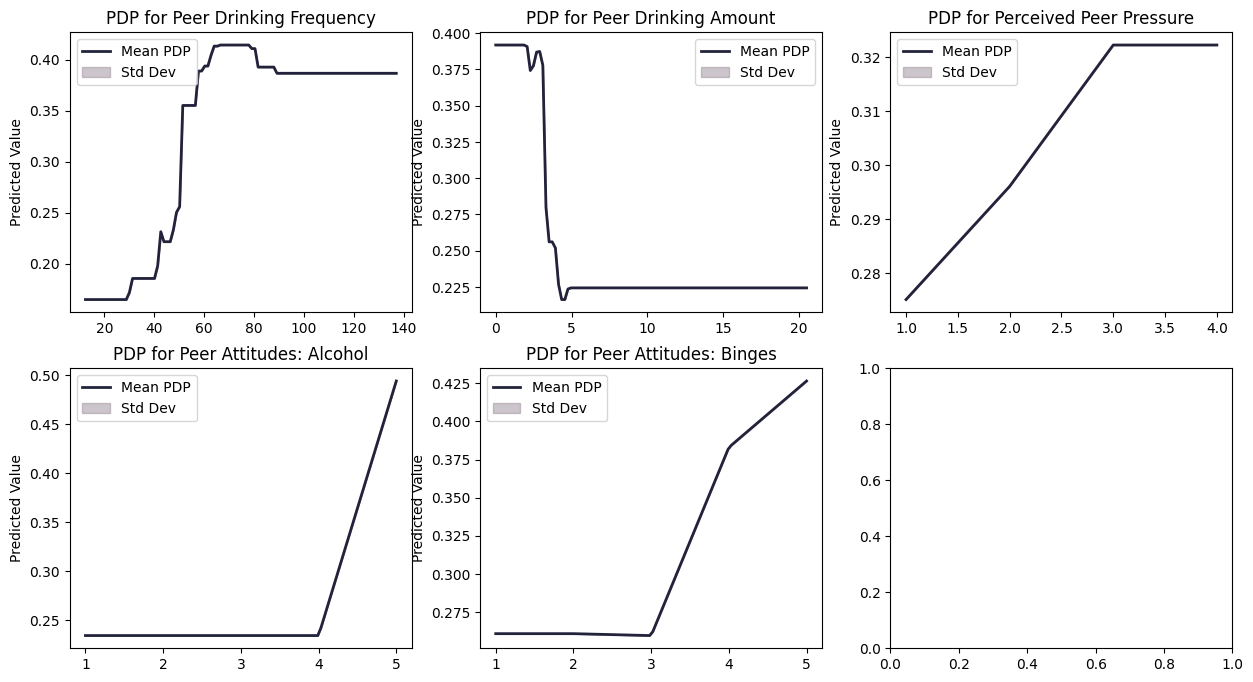

In [46]:
res_dir = '../results/1750850599_321_rf_outer100_cvrep5_k3_auc_testsize0.3_permFalse'
loaded_model = joblib.load(f'{res_dir}/model_group_sub.joblib')
# Out-of sample testing, without resampling
res_dir = os.path.join(res_dir, 'oos_test') 
scores, best_params = test_oos(b2_group_subjective_test, res_dir, loaded_model, None, plot=True)
print(scores)

In [ ]:
def evaluate_top_models(res_dir, test_df, target_col='responsive', group_name="('group_sub',)", 
                        top_n=10, n_iterations=10, desired_positive_rate=0.24, plot=False):
    """
    Loads top N models from a result directory, resamples the test set with a desired positive rate, 
    and evaluates each model over multiple iterations.

    Returns:
        summary_df: DataFrame with mean and 95% CI for each metric.
        all_scores_df: Raw scores from each resampling.
    """
    # Load test metrics to identify top models
    df_scores = pd.read_csv(os.path.join(res_dir, "all_test_scores.csv"))
    group_df = df_scores[df_scores['group'] == group_name]

    # Select top models based on AUC
    top_indices = group_df['auc'].nlargest(top_n).index.tolist()

    # Load corresponding models from saved files
    top_models = []
    model_dir = os.path.join(res_dir, "top10_group_sub_models")

    for i in range(1, top_n + 1):
        pattern = os.path.join(model_dir, f"model_rank{i}_*.joblib")
        matched_files = glob.glob(pattern)
        if matched_files:
            top_models.append(joblib.load(matched_files[0]))

    if len(top_models) == 0:
        raise ValueError(f"No models found")

    # Drop missing values
    test_df = test_df.dropna()

    # Split positives and negatives
    positive_cases = test_df[test_df[target_col] == 1]
    negative_cases = test_df[test_df[target_col] == 0]

    all_scores = []

    for model in tqdm(top_models, desc="Evaluating top models"):
        for _ in range(n_iterations):
            # Stratified resampling
            total_samples = len(test_df)
            n_pos = int(total_samples * desired_positive_rate)
            n_neg = total_samples - n_pos

            pos_sample = resample(positive_cases, replace=True, n_samples=n_pos, random_state=None)
            neg_sample = resample(negative_cases, replace=False, n_samples=n_neg, random_state=None)

            balanced_df = pd.concat([pos_sample, neg_sample]).sample(frac=1).reset_index(drop=True)

            scores, _ = test_oos(balanced_df, res_dir, model, [], plot=plot)
            all_scores.append(scores)

    scores_df = pd.DataFrame(all_scores)

    # Compute summary
    mean_scores = scores_df.mean()
    ci_lower, ci_upper = st.t.interval(0.95, df=len(scores_df)-1, loc=mean_scores, scale=scores_df.sem())

    summary_df = pd.DataFrame({
        'Mean': mean_scores,
        '95% CI Lower': ci_lower,
        '95% CI Upper': ci_upper
    })

    return summary_df, scores_df


In [ ]:
# Out of sample testing with resampling to the positive rate of the training data
if SEED:
    np.random.seed(SEED)

res_dir = '../results/1750853719_321_rf_outer100_cvrep5_k3_auc_testsize0.3_permFalse'
summary_df, all_scores_df = evaluate_top_models(
    res_dir=res_dir,
    test_df=b2_group_subjective_test,
    top_n=1,
    n_iterations=100,
    desired_positive_rate=0.22,
    plot=False
)

In [ ]:
summary_df

### Sensitivity Analyses

Run CV with different values for k and different train/validation splits.

In [ ]:
# Sensitivity 
run_rf_train_test(
    dataframes=dataframes,
    param_grid=param_grid,
    eval_metrics=eval_metrics,
    outer_reps=100,
    k=3,
    CV_reps=5,
    model_choice_metric='auc',
    res_dir="../results/",
    model_type='rf',
    test_set=0.4,
    resampling=None,
    permutation=False
)

run_rf_train_test(
    dataframes=dataframes,
    param_grid=param_grid,
    eval_metrics=eval_metrics,
    outer_reps=100,
    k=5,
    CV_reps=5,
    model_choice_metric='auc',
    res_dir="../results/",
    model_type='rf',
    test_set=0.3,
    resampling=None,
    permutation=False
)